In [13]:
from regain.datasets.kernels import make_cluster_representative
from regain.datasets.ising import ising_theta_generator, ising_sampler

from itertools import chain, combinations

import numpy as np
from scipy import linalg
from scipy.spatial.distance import squareform
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets.base import Bunch

from regain.norm import l1_od_norm
from regain.utils import is_pos_def

In [169]:
def make_cluster_representative(
        n_dim=10, degree=2, n_clusters=3, T=15, n_samples=100, repetitions=False,
        cluster_series=None, shuffle=False):
    """Based on the cluster representative, generate similar graphs."""
    import networkx as nx
    adjacencies = []
    if cluster_series is not None:
        n_clusters = np.unique(cluster_series).size

    for i in range(n_clusters):
        adjacencies.append(ising_theta_generator(p=n_dim, T=1, time_on_axis='first',responses=[-1, 1])[0])
    pos = np.arange(0, T, T // (n_clusters + 1))
    pos = list(pos) + [T - 1]

    if cluster_series is None:
        cluster_series = np.tile(range(n_clusters), (len(pos) // n_clusters) + 1)[:len(pos)]
        if shuffle:
            np.random.shuffle(cluster_series)
        # print(pos)
        # print(cluster_series)
        # pos = np.arange(0, T, T // (clusters + 1))
        # pos = list(pos) + [T - 1]
    else:
        #assert len(cluster_series) == len(pos)
        a = np.where(cluster_series[:-1] != cluster_series[1:])[0] + 1
        T = len(cluster_series) # overwrites T
        pos = np.concatenate(([0], a, [T-1]))

    thetas = []
    for i in range(len(pos) - 1):
        # last one is always a representative
        how_many = int(pos[i + 1]) - int(pos[i]) - 1
        new_list = [adjacencies[cluster_series[i]]]
        target = adjacencies[cluster_series[i + 1]]

        for i in range(how_many):
            new = new_list[-1].copy()
            diffs = (new != 0).astype(int) - (target != 0).astype(int)
            diff = np.where(diffs != 0)
            if diff == ():
                break
            if (i == 0):
                edges_per_change = int(
                    (np.nonzero(diffs)[0].shape[0] / 2) // (how_many + 1))
                if edges_per_change == 0:
                    edges_per_change += 1
            ixs = np.arange(diff[0].shape[0])
            np.random.shuffle(ixs)

            xs = diff[0][ixs[:edges_per_change]]
            ys = diff[1][ixs[:edges_per_change]]
            for j in range(xs.shape[0]):
                if diffs[xs[j], ys[j]] == -1:
                    new[xs[j], ys[j]] = np.random.choice([-1,1])
                    new[ys[j], xs[j]] = new[xs[j], ys[j]]
                else:
                    new[xs[j], ys[j]] = 0
                    new[ys[j], xs[j]] = 0
            new_list.append(new)

        thetas += new_list
    thetas.append(target)
    X = np.vstack(
        [
            ising_sampler(t,thresholds=np.zeros(n_samples), n=n_samples, responses=[-1,1])
            for t in thetas
        ])
    y = np.repeat(np.arange(len(thetas)), n_samples)

    distances = squareform(
        [l1_od_norm(t1 - t2) for t1, t2 in combinations(thetas, 2)])
    distances /= np.max(distances)
    labels_pred = AgglomerativeClustering(
        n_clusters=n_clusters, affinity='precomputed',
        linkage='complete').fit_predict(distances)

    id_cluster = np.repeat(labels_pred, n_samples)
    data = Bunch(
        X=X, y=y, id_cluster=labels_pred, samples_cluster=id_cluster, precs=np.array(thetas),
        thetas=np.array(thetas), sparse_precs=np.array(thetas),
        cluster_reps=adjacencies, cluster_series=cluster_series)
    return data

In [170]:
res = make_cluster_representative(cluster_series=[0,0,1,2,0,1,2,2,2,0,0], n_samples=100)

In [171]:
import pickle as pkl

with open('random-patterned-data.pkl', 'wb') as f:
    pkl.dump(res, f)

In [154]:
from importlib import reload
import regain.generalized_temporal_linear_model.ising; reload(regain.generalized_temporal_linear_model.ising)
from regain.generalized_temporal_linear_model.ising import SimilarityTemporalIsingModel, TemporalIsingModel

In [158]:
# mdl_ = TemporalIsingModel(alpha=0.01, kernel=np.zeros((15, 15)), verbose=2)
# mdl_.fit(res['X'], res['y'])
from importlib import reload
import regain.generalized_temporal_linear_model.ising; reload(regain.generalized_temporal_linear_model.ising)
from regain.generalized_temporal_linear_model.ising import SimilarityTemporalIsingModel, TemporalIsingModel
from sklearn.gaussian_process import kernels
temporal_kernel = kernels.ExpSineSquared(
    periodicity=10,
    length_scale=3)(np.arange(15)[:, None])
mdl_ = TemporalIsingModel(alpha=0.8, kernel=temporal_kernel, verbose=0)


mdl = SimilarityTemporalIsingModel(alpha=0.5,n_clusters=3, beta=1,
                                   psi='l1', verbose=0)

thetas = []
precisions_similarity = []
precisions_periodic = []
for i in range(10):
    res = make_cluster_representative(n_samples=100)
    thetas.append(res['precs'])
    mdl.fit(res['X'], res['y'])
    precisions_similarity.append(mdl.precision_)
    mdl_.fit(res['X'], res['y'])
    precisions_periodic.append(mld_.precision_)

(15, 10, 10)
(15, 10, 10)
[[2.00000000e+00 1.60653066e+00 1.35335283e-01 1.11089965e-02
  1.00033546e+00 3.72665317e-06 1.52299797e-08 1.00000000e+00
  1.00000000e+00 2.57675711e-18 1.92874985e-22 1.00000000e+00
  5.38018616e-32 2.00500878e-37 2.74878501e-43]
 [1.60653066e+00 2.00000000e+00 6.06530660e-01 1.35335283e-01
  1.01110900e+00 3.35462628e-04 3.72665317e-06 1.00000002e+00
  1.00000000e+00 1.26641655e-14 2.57675711e-18 1.00000000e+00
  5.31109225e-27 5.38018616e-32 2.00500878e-37]
 [1.35335283e-01 6.06530660e-01 2.00000000e+00 1.60653066e+00
  1.35335283e-01 1.01110900e+00 1.00033546e+00 3.72665317e-06
  1.52299797e-08 1.00000000e+00 1.26641655e-14 2.57675711e-18
  1.92874985e-22 5.31109225e-27 5.38018616e-32]
 [1.11089965e-02 1.35335283e-01 1.60653066e+00 2.00000000e+00
  6.06530660e-01 1.13533528e+00 1.01110900e+00 3.35462628e-04
  3.72665317e-06 1.00000002e+00 2.28973485e-11 1.26641655e-14
  2.57675711e-18 1.92874985e-22 5.31109225e-27]
 [1.00033546e+00 1.01110900e+00 1.3533

/home/vero/git_repos/regain/regain/generalized_temporal_linear_model/ising.py:243: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


[[2.00000000e+00 6.06530660e-01 1.13533528e+00 1.01110900e+00
  3.35462628e-04 1.00000373e+00 1.00000002e+00 2.28973485e-11
  1.26641655e-14 2.57675711e-18 1.92874985e-22 5.31109225e-27
  5.38018616e-32 2.00500878e-37 2.74878501e-43]
 [6.06530660e-01 2.00000000e+00 6.06530660e-01 1.35335283e-01
  1.01110900e+00 3.35462628e-04 3.72665317e-06 1.00000002e+00
  1.00000000e+00 1.26641655e-14 2.57675711e-18 1.00000000e+00
  5.31109225e-27 5.38018616e-32 2.00500878e-37]
 [1.13533528e+00 6.06530660e-01 2.00000000e+00 1.60653066e+00
  1.35335283e-01 1.01110900e+00 1.00033546e+00 3.72665317e-06
  1.52299797e-08 2.28973485e-11 1.26641655e-14 2.57675711e-18
  1.92874985e-22 5.31109225e-27 5.38018616e-32]
 [1.01110900e+00 1.35335283e-01 1.60653066e+00 2.00000000e+00
  6.06530660e-01 1.13533528e+00 1.01110900e+00 3.35462628e-04
  3.72665317e-06 1.52299797e-08 2.28973485e-11 1.26641655e-14
  2.57675711e-18 1.92874985e-22 5.31109225e-27]
 [3.35462628e-04 1.01110900e+00 1.35335283e-01 6.06530660e-01
  

/home/vero/git_repos/regain/regain/generalized_temporal_linear_model/ising.py:243: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


[[2.00000000e+00 1.60653066e+00 1.35335283e-01 1.11089965e-02
  1.00033546e+00 3.72665317e-06 1.52299797e-08 1.00000000e+00
  1.00000000e+00 2.57675711e-18 1.92874985e-22 1.00000000e+00
  5.38018616e-32 2.00500878e-37 2.74878501e-43]
 [1.60653066e+00 2.00000000e+00 6.06530660e-01 1.35335283e-01
  1.01110900e+00 3.35462628e-04 3.72665317e-06 1.00000002e+00
  1.00000000e+00 1.26641655e-14 2.57675711e-18 1.00000000e+00
  5.31109225e-27 5.38018616e-32 2.00500878e-37]
 [1.35335283e-01 6.06530660e-01 2.00000000e+00 1.60653066e+00
  1.35335283e-01 1.01110900e+00 1.00033546e+00 3.72665317e-06
  1.52299797e-08 1.00000000e+00 1.26641655e-14 2.57675711e-18
  1.92874985e-22 5.31109225e-27 5.38018616e-32]
 [1.11089965e-02 1.35335283e-01 1.60653066e+00 2.00000000e+00
  6.06530660e-01 1.13533528e+00 1.01110900e+00 3.35462628e-04
  3.72665317e-06 1.00000002e+00 2.28973485e-11 1.26641655e-14
  2.57675711e-18 1.92874985e-22 5.31109225e-27]
 [1.00033546e+00 1.01110900e+00 1.35335283e-01 6.06530660e-01
  

/home/vero/git_repos/regain/regain/generalized_temporal_linear_model/ising.py:243: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


[[2.00000000e+00 6.06530660e-01 1.13533528e+00 1.01110900e+00
  3.35462628e-04 1.00000373e+00 1.00000002e+00 2.28973485e-11
  1.26641655e-14 2.57675711e-18 1.92874985e-22 5.31109225e-27
  5.38018616e-32 2.00500878e-37 2.74878501e-43]
 [6.06530660e-01 2.00000000e+00 6.06530660e-01 1.35335283e-01
  1.01110900e+00 3.35462628e-04 3.72665317e-06 1.00000002e+00
  1.00000000e+00 1.26641655e-14 2.57675711e-18 1.00000000e+00
  5.31109225e-27 5.38018616e-32 2.00500878e-37]
 [1.13533528e+00 6.06530660e-01 2.00000000e+00 1.60653066e+00
  1.35335283e-01 1.01110900e+00 1.00033546e+00 3.72665317e-06
  1.52299797e-08 2.28973485e-11 1.26641655e-14 2.57675711e-18
  1.92874985e-22 5.31109225e-27 5.38018616e-32]
 [1.01110900e+00 1.35335283e-01 1.60653066e+00 2.00000000e+00
  6.06530660e-01 1.13533528e+00 1.01110900e+00 3.35462628e-04
  3.72665317e-06 1.52299797e-08 2.28973485e-11 1.26641655e-14
  2.57675711e-18 1.92874985e-22 5.31109225e-27]
 [3.35462628e-04 1.01110900e+00 1.35335283e-01 6.06530660e-01
  

/home/vero/git_repos/regain/regain/generalized_temporal_linear_model/ising.py:243: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


[[2.00000000e+00 1.60653066e+00 1.35335283e-01 1.11089965e-02
  1.00033546e+00 3.72665317e-06 1.52299797e-08 1.00000000e+00
  1.00000000e+00 2.57675711e-18 1.92874985e-22 1.00000000e+00
  5.38018616e-32 2.00500878e-37 2.74878501e-43]
 [1.60653066e+00 2.00000000e+00 6.06530660e-01 1.35335283e-01
  1.01110900e+00 3.35462628e-04 3.72665317e-06 1.00000002e+00
  1.00000000e+00 1.26641655e-14 2.57675711e-18 1.00000000e+00
  5.31109225e-27 5.38018616e-32 2.00500878e-37]
 [1.35335283e-01 6.06530660e-01 2.00000000e+00 1.60653066e+00
  1.35335283e-01 1.01110900e+00 1.00033546e+00 3.72665317e-06
  1.52299797e-08 1.00000000e+00 1.26641655e-14 2.57675711e-18
  1.92874985e-22 5.31109225e-27 5.38018616e-32]
 [1.11089965e-02 1.35335283e-01 1.60653066e+00 2.00000000e+00
  6.06530660e-01 1.13533528e+00 1.01110900e+00 3.35462628e-04
  3.72665317e-06 1.00000002e+00 2.28973485e-11 1.26641655e-14
  2.57675711e-18 1.92874985e-22 5.31109225e-27]
 [1.00033546e+00 1.01110900e+00 1.35335283e-01 6.06530660e-01
  

KeyboardInterrupt: 

In [163]:
from regain.utils import structure_error
def mean_res(thetas, results):
    print(results)
    dictionary = dict(
        tp=[], tn=[], fp=[], fn=[], precision=[], recall=[], f1=[],
        accuracy=[], false_omission_rate=[],
        fdr=[], npv=[],
        prevalence=[], miss_rate=[], fall_out=[],
        specificity=[], plr=[],
        nlr=[], dor=[], mcc=[],
        balanced_accuracy=[],
        average_precision=[])
  
    for i in range(10):
        res = structure_error(np.array(thetas[i]), results[i], no_diagonal=True)
        for k, v in res.items():
                dictionary[k].append(v)
    
    res_stat = {}
    for k, l in dictionary.items():
        res_stat[k] = str(round(np.mean(l),2))+"+/-"+str(round(np.std(l),2))
    return res_stat

In [165]:
mean_res(thetas, precisions_similarity)

[]


IndexError: list index out of range

In [156]:
mdl = SimilarityTemporalIsingModel(alpha=0.5,n_clusters=3, beta=1, psi='l1', verbose=1)
mdl.fit(res['X'], res['y'])

(15, 10, 10)
obj: 8690.8953, rnorm: 0.0000, snorm: 2.8539,eps_pri: 0.0153, eps_dual: 0.0150
(15, 10, 10)
obj: 8690.7501, rnorm: 0.0000, snorm: 0.0001,eps_pri: 0.0153, eps_dual: 0.0150
[[2.00000000e+00 6.06530660e-01 1.13533528e+00 1.01110900e+00
  3.35462628e-04 1.00000373e+00 1.00000002e+00 2.28973485e-11
  1.00000000e+00 2.57675711e-18 1.00000000e+00 5.31109225e-27
  5.38018616e-32 2.00500878e-37 2.74878501e-43]
 [6.06530660e-01 2.00000000e+00 6.06530660e-01 1.35335283e-01
  1.11089965e-02 3.35462628e-04 3.72665317e-06 1.00000002e+00
  2.28973485e-11 1.26641655e-14 2.57675711e-18 1.00000000e+00
  1.00000000e+00 5.38018616e-32 2.00500878e-37]
 [1.13533528e+00 6.06530660e-01 2.00000000e+00 1.60653066e+00
  1.35335283e-01 1.01110900e+00 1.00033546e+00 3.72665317e-06
  1.00000002e+00 2.28973485e-11 1.00000000e+00 2.57675711e-18
  1.92874985e-22 5.31109225e-27 5.38018616e-32]
 [1.01110900e+00 1.35335283e-01 1.60653066e+00 2.00000000e+00
  6.06530660e-01 1.13533528e+00 1.01110900e+00 3.354

KeyboardInterrupt: 

In [126]:


labels_pred = AgglomerativeClustering(
                    n_clusters=3, affinity='precomputed',
                    linkage='complete').fit_predict(mdl.similarity_matrix_)

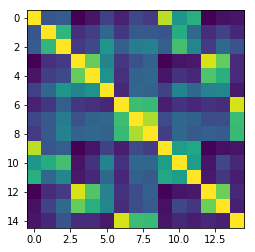

In [127]:
import matplotlib.pyplot as plt

plt.imshow(mdl.similarity_matrix_)
plt.show()

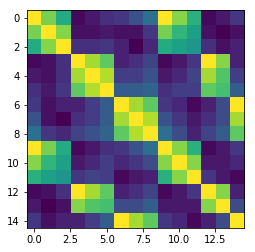

In [128]:
plt.imshow(1-squareform(
        [l1_od_norm(t1 - t2) for t1, t2 in combinations(res['precs'], 2)]))
plt.show()

In [129]:
labels_pred

array([0, 1, 2, 2, 1, 0, 1, 0, 1, 2, 0, 1, 0, 1, 0])

In [130]:
res['id_cluster']

array([0, 0, 0, 1, 1, 1, 2, 2, 2, 0, 0, 0, 1, 1, 2])

In [132]:
from sklearn.metrics import v_measure_score
v_measure_score(res['id_cluster'], labels_pred)

0.07382423648483274

In [124]:
from regain.utils import structure_error

structure_error(res['thetas'], mdl.precision_, no_diagonal=True)

{'tp': 416,
 'tn': 324,
 'fp': 172,
 'fn': 438,
 'precision': 0.7074829931972789,
 'recall': 0.48711943793911006,
 'f1': 0.5769764216366159,
 'accuracy': 0.49333333333333335,
 'false_omission_rate': 0.5748031496062992,
 'fdr': 0.2925170068027211,
 'npv': 0.4251968503937008,
 'prevalence': 0.5693333333333334,
 'miss_rate': 0.5128805620608899,
 'fall_out': 0.3467741935483871,
 'specificity': 0.6532258064516129,
 'plr': 1.4047165187081312,
 'nlr': 0.7851504900685229,
 'dor': 1.7891048104491873,
 'balanced_accuracy': 0.5701726221953615,
 'average_precision': 0.6227595124795988,
 'mcc': 0.4283848758846295}

In [137]:
from sklearn.gaussian_process import kernels
temporal_kernel = kernels.ExpSineSquared(
    periodicity=10,
    length_scale=3)(np.arange(15)[:, None])
mdl_ = TemporalIsingModel(alpha=0.8, kernel=temporal_kernel, verbose=0)
mdl_.fit(res['X'], res['y'])

(15, 10, 10)
(15, 10, 10)
(15, 10, 10)
(15, 10, 10)
(15, 10, 10)
(15, 10, 10)
(15, 10, 10)
(15, 10, 10)
(15, 10, 10)
(15, 10, 10)
(15, 10, 10)
(15, 10, 10)
(15, 10, 10)
(15, 10, 10)
(15, 10, 10)
(15, 10, 10)


TemporalIsingModel(alpha=0.8, assume_centered=False, compute_objective=True,
          distribution='ising', init='empirical', ker_param=1,
          kernel=array([[1.     , 0.979  , ..., 0.86464, 0.81791],
       [0.979  , 1.     , ..., 0.9261 , 0.86464],
       ...,
       [0.86464, 0.9261 , ..., 1.     , 0.979  ],
       [0.81791, 0.86464, ..., 0.979  , 1.     ]]),
          max_iter=100, max_iter_ext=100, n_cores=-1, psi='laplacian',
          return_history=False, rho=1.0, rtol=0.0001, tol=0.0001,
          update_rho_options=None, verbose=0)

In [138]:
structure_error(res['thetas'], mdl_.precision_, no_diagonal=True)

{'tp': 522,
 'tn': 282,
 'fp': 214,
 'fn': 332,
 'precision': 0.7092391304347826,
 'recall': 0.6112412177985949,
 'f1': 0.6566037735849056,
 'accuracy': 0.536,
 'false_omission_rate': 0.5407166123778502,
 'fdr': 0.2907608695652174,
 'npv': 0.4592833876221498,
 'prevalence': 0.5693333333333334,
 'miss_rate': 0.38875878220140514,
 'fall_out': 0.4314516129032258,
 'specificity': 0.5685483870967742,
 'plr': 1.4167086169537526,
 'nlr': 0.6837743119570813,
 'dor': 2.0718950568629664,
 'balanced_accuracy': 0.5898948024476846,
 'average_precision': 0.6596295480998629,
 'mcc': 0.46279061618302453}

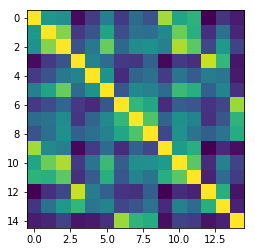

In [139]:
from regain.generalized_temporal_linear_model.ising import precision_similarity

A = precision_similarity(mdl_.precision_)
plt.imshow(A)
plt.show()

In [144]:

labels_pred2 = AgglomerativeClustering(
                    n_clusters=3, affinity='precomputed',
                    linkage='complete').fit_predict(A)

In [145]:
v_measure_score(res['id_cluster'], labels_pred2)

0.010536873366270065

In [146]:
labels_pred2

array([1, 2, 1, 1, 2, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0])

In [143]:
labels_pred

array([0, 1, 2, 2, 1, 0, 1, 0, 1, 2, 0, 1, 0, 1, 0])

In [147]:
res

{'X': array([[ 1, -1, -1, ...,  1, -1, -1],
        [-1,  1,  1, ..., -1,  1,  1],
        [ 1, -1, -1, ...,  1, -1, -1],
        ...,
        [-1, -1,  1, ..., -1, -1, -1],
        [-1, -1,  1, ..., -1, -1, -1],
        [-1, -1,  1, ..., -1, -1, -1]]),
 'y': array([ 0,  0,  0, ..., 14, 14, 14]),
 'id_cluster': array([0, 0, 0, 1, 1, 1, 2, 2, 2, 0, 0, 0, 1, 1, 2]),
 'samples_cluster': array([0, 0, 0, ..., 2, 2, 2]),
 'precs': array([[[ 0.,  1.,  0., ...,  0., -1.,  0.],
         [ 1.,  0.,  1., ..., -1.,  0.,  0.],
         [ 0.,  1.,  0., ..., -1.,  1., -1.],
         ...,
         [ 0., -1., -1., ...,  0.,  0., -1.],
         [-1.,  0.,  1., ...,  0.,  0.,  0.],
         [ 0.,  0., -1., ..., -1.,  0.,  0.]],
 
        [[ 0.,  1.,  0., ...,  0., -1.,  1.],
         [ 1.,  0.,  1., ..., -1.,  0., -1.],
         [ 0.,  1.,  0., ..., -1.,  1.,  0.],
         ...,
         [ 0., -1., -1., ...,  0.,  0.,  0.],
         [-1.,  0.,  1., ...,  0.,  0.,  1.],
         [ 1., -1.,  0., ...,  0., 